In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import os
import phate
import scprep
import numpy as np

import plotnine as p9
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_bar, geom_histogram

from maud import io, utils, code_generation, sampling

%matplotlib inline

here = os.getcwd()
home = os.path.join(here, "../../../")

PATHS = {
    'DATA': os.path.join(home, "data/july-2020/"),
    'RESULTS': os.path.join(home, "results/july-2020/yeast_ma"),
    'DOC': os.path.join(home, "doc")
}

In [2]:
def get_keys(stan_codes):
    return [key for key in stan_codes.keys()]

In [3]:
mi = io.load_maud_input_from_toml(os.path.join(PATHS['DATA'], 'yeast_ethanol_fx_no_split_compartment.toml'))
mi_validation = io.load_maud_input_from_toml(os.path.join(PATHS['DATA'], 'yeast_validation.toml'))

experiment_codes = get_keys(mi.stan_codes["experiment"])
reaction_codes = get_keys(mi.stan_codes["reaction"])
enzyme_codes = get_keys(mi.stan_codes["enzyme"])
metabolite_codes = get_keys(mi.stan_codes["metabolite"])
kinetic_parameter_codes = get_keys(mi.stan_codes["kinetic_parameter"])
mic_codes = get_keys(mi.stan_codes["metabolite_in_compartment"])
balanced_mic_codes = get_keys(mi.stan_codes["balanced_mic"])

In [4]:
relative_metabolite_changes = pd.read_csv(os.path.join(PATHS['DATA'], "relative_concentrations.csv"))
relative_metabolite_changes = pd.melt(relative_metabolite_changes, 
                                      id_vars=['mic'], 
                                      value_vars=experiment_codes,
                                      var_name='experiments')

In [5]:
times = ['0.0001', '0.001', '0.01', '0.1', '1', '10', '100', '1000']

In [51]:
# # Given a pulse of 2*g6p
# conc_distributions = pd.read_csv(os.path.join(PATHS['RESULTS'], "yeast_ethanol_fx_no_split_compartment_ode_results.csv"))
# dG_distributions = pd.read_csv(os.path.join(PATHS['RESULTS'], "yeast_ethanol_fx_no_split_compartment_dG_results.csv"))
# flux_distributions = pd.read_csv(os.path.join(PATHS['RESULTS'], "yeast_ethanol_fx_no_split_compartment_flux_results.csv"))
# reg_distributions = pd.read_csv(os.path.join(PATHS['RESULTS'], "yeast_ethanol_fx_no_split_compartment_reg_results.csv"))
# for time in times:
#     reg_distributions[time] = reg_distributions[time].apply(np.float)
#     flux_distributions[time] = flux_distributions[time].apply(np.float)
# reg_distributions = reg_distributions[reg_distributions['0.0001'] > 0].reset_index(drop=True)
# norm_reg = reg_distributions['0.0001'].copy(deep=True)
# flux_reg = flux_distributions['0.0001'].copy(deep=True)
# for time in times:
#     reg_distributions[time] = reg_distributions[time]/norm_reg

    
# conc_distributions.rename({"Unnamed: 0": "met_run"}, axis=1, inplace=True)
# dG_distributions.rename({"Unnamed: 0": "dG_run"}, axis=1, inplace=True)
# flux_distributions.rename({"Unnamed: 0": "flux_run"}, axis=1, inplace=True)
# reg_distributions.rename({"Unnamed: 0": "reg_run"}, axis=1, inplace=True)

In [52]:
# times = conc_distributions.columns[-8:]
# tidy_conc_pulse = pd.melt(conc_distributions, id_vars=['experiment_code', 'metabolite_code', 'met_run'], value_vars=times)
# tidy_dG_pulse = pd.melt(dG_distributions, id_vars=['experiment_code', 'enzyme_code', 'dG_run'], value_vars=times)
# tidy_flux_pulse = pd.melt(flux_distributions, id_vars=['experiment_code', 'reaction_code', 'flux_run'], value_vars=times)
# tidy_reg_pulse = pd.melt(reg_distributions, id_vars=['experiment_code', 'enzyme_code', 'reg_run'], value_vars=times)

# tidy_conc_pulse['variable'] = tidy_conc_pulse['variable'].apply(np.float)
# tidy_dG_pulse['variable'] = tidy_dG_pulse['variable'].apply(np.float)
# tidy_flux_pulse['variable'] = tidy_flux_pulse['variable'].apply(np.float)
# tidy_reg_pulse['variable'] = tidy_reg_pulse['variable'].apply(np.float)
# tidy_reg_pulse = tidy_reg_pulse[tidy_reg_pulse['value'] != 0]

# tidy_conc_pulse['value'] = tidy_conc_pulse['value'].apply(np.float)
# tidy_dG_pulse['value'] = tidy_dG_pulse['value'].apply(np.float)
# tidy_flux_pulse['value'] = tidy_flux_pulse['value'].apply(np.float)
# tidy_reg_pulse['value'] = tidy_reg_pulse['value'].apply(np.float)

# Validation

In [556]:
conc_distributions_val = pd.read_csv(os.path.join(PATHS['RESULTS'], "yeast_ethanol_fx_no_split_compartment_ode_results_validation.csv"))
flux_distributions_val = pd.read_csv(os.path.join(PATHS['RESULTS'], "yeast_ethanol_fx_no_split_compartment_flux_results_validation.csv"))
for time in times:
    flux_distributions_val[time] = flux_distributions_val[time].apply(np.float)
    
conc_distributions_val.rename({"Unnamed: 0": "met_run"}, axis=1, inplace=True)
flux_distributions_val.rename({"Unnamed: 0": "flux_run"}, axis=1, inplace=True)

In [557]:
times = conc_distributions_val.columns[-8:]
tidy_conc_pulse_val = pd.melt(conc_distributions_val, id_vars=['experiment_code', 'metabolite_code', 'met_run'], value_vars=times)
tidy_flux_pulse_val = pd.melt(flux_distributions_val, id_vars=['experiment_code', 'reaction_code', 'flux_run'], value_vars=times)

tidy_conc_pulse_val['variable'] = tidy_conc_pulse_val['variable'].apply(np.float)
tidy_flux_pulse_val['variable'] = tidy_flux_pulse_val['variable'].apply(np.float)

tidy_conc_pulse_val['conc'] = tidy_conc_pulse_val['value'].apply(np.float)
tidy_flux_pulse_val['flux'] = tidy_flux_pulse_val['value'].apply(np.float)
tidy_conc_pulse_val.drop('value', axis=1, inplace=True)
tidy_flux_pulse_val.drop('value', axis=1, inplace=True)
tidy_flux_pulse_val_meas = tidy_flux_pulse_val.merge(reaction_measurements, left_on=['experiment_code', 'reaction_code'], right_on=['experiment_id', 'target_id'])
tidy_conc_pulse_val_meas = tidy_conc_pulse_val.merge(mic_measurements, left_on=['experiment_code', 'metabolite_code'], right_on=['experiment_id', 'target_id'])

In [6]:
enzyme_validation = pd.DataFrame(columns = [
    'reaction',
    'enzyme',
    'experiment',
    'enzyme_concentration',
    'kcat_prior',
    'reaction_flux',
    'scaling_factor'
])


rxn_enz_dict = {
    rxn_name: list(rxn_data.enzymes.keys())
    for rxn_name, rxn_data in mi.kinetic_model.reactions.items()
}

count = 0

for exp_name, exp in mi.experiments.items():
    for rxn, flux in exp.measurements['reaction'].items():
        tmp_enz_kcat_array = []
        Vmax = 0
        for enz in rxn_enz_dict[rxn]:
            try:
                tmp_enz_kcat_array.append([enz, exp.measurements['enzyme'][enz].value, mi.priors[f'{enz}_Kcat1'].location])
            except:
                print(f"The enzyme: {enz} wasn't measured in experiment: {exp_name}")
                tmp_enz_kcat_array.append([enz, 0.1, mi.priors[f'{enz}_Kcat1'].location])
            Vmax += tmp_enz_kcat_array[-1][1] * tmp_enz_kcat_array[-1][2]
        if Vmax < np.abs(flux.value):
            scaling_factor = 1.5 * flux.value / Vmax
        else:
            scaling_factor = 1
            
        for enz in tmp_enz_kcat_array:
            enzyme_validation.loc[count, 'reaction'] = rxn
            enzyme_validation.loc[count, 'enzyme'] = enz[0]
            enzyme_validation.loc[count, 'experiment'] = exp_name
            enzyme_validation.loc[count, 'enzyme_concentration'] = enz[1]
            enzyme_validation.loc[count, 'kcat_prior'] = enz[2]
            enzyme_validation.loc[count, 'reaction_flux'] = np.abs(flux.value)
            enzyme_validation.loc[count, 'scaling_factor'] = scaling_factor
            count += 1

The enzyme: pyr_c_EX wasn't measured in experiment: C0.05


KeyError: 'pyr_c_EX_Kcat1'

In [7]:
measurement_coords = [
    f'{meas_id}//{exp_name}//{value.value}'
    for exp_name, exp in mi.experiments.items()
    for meas_type, measurement in exp.measurements.items()
    for meas_id, value in measurement.items() if meas_type not in ['enzyme']
]

measurement_coords_enz = [
    f'{meas_id}//{exp_name}//{value.value}'
    for exp_name, exp in mi.experiments.items()
    for meas_type, measurement in exp.measurements.items()
    for meas_id, value in measurement.items() if meas_type in ['enzyme']
]

mic_measurements, reaction_measurements, enzyme_measurements = (
        pd.DataFrame(
            [
                [exp.id, meas.target_id, meas.value, meas.uncertainty]
                for exp in mi_validation.experiments.values()
                for meas in exp.measurements[measurement_type].values()
            ],
            columns=["experiment_id", "target_id", "value", "uncertainty"],
        )
        for measurement_type in ["metabolite", "reaction", "enzyme"]
    )

In [8]:
measurement_coords_ordered = pd.DataFrame()
measurement_coords_enz_ordered = pd.DataFrame()
measurement_coords_ordered['measurement_id'] = measurement_coords
measurement_coords_enz_ordered['measurement_id'] = measurement_coords_enz
data_series = measurement_coords_ordered['measurement_id'].str.split('//')
data_series_enz = measurement_coords_enz_ordered['measurement_id'].str.split('//')

In [9]:
measurement_data = pd.DataFrame(data_series.to_list(), columns=['measurement_id', 'experiment', 'value'])
measurement_data_enz = pd.DataFrame(data_series_enz.to_list(), columns=['measurement_id', 'experiment', 'value'])
measurement_coords_new = measurement_coords_ordered.copy(deep=True)
measurement_coords_enz_new = measurement_coords_enz_ordered.copy(deep=True)
measurement_coords_new['measurement_id'] = measurement_data['measurement_id']
measurement_coords_enz_new['measurement_id'] = measurement_data_enz['measurement_id']
measurement_coords_new['experiment'] = measurement_data['experiment']
measurement_coords_enz_new['experiment'] = measurement_data_enz['experiment']
measurement_coords_new['value'] = measurement_data['value']
measurement_coords_enz_new['value'] = measurement_data_enz['value']

In [10]:
meas_codes = mic_codes + enzyme_codes
meas_index = pd.DataFrame(meas_codes, columns=['measurement_id'])
meas_index['order'] = [i for i in range(meas_index.shape[0])]
enz_index = pd.DataFrame(enzyme_codes, columns=['measurement_id'])
enz_index['order'] = [i for i in range(enz_index.shape[0])]

In [11]:
measurement_coords_new = measurement_coords_new.merge(meas_index, on='measurement_id', how='left')
measurement_coords_enz_new = measurement_coords_enz_new.merge(enz_index, on='measurement_id', how='left')

for exp in experiment_codes:
    measurement_coords_new[measurement_coords_new['experiment']==exp].sort_values(by='order', inplace=True)
    measurement_coords_enz_new[measurement_coords_enz_new['experiment']==exp].sort_values(by='order', inplace=True)

measurement_coords_new.drop(['order'], axis=1, inplace=True)
measurement_coords_enz_new.drop(['order'], axis=1, inplace=True)
measurement_coords_new['value'] = measurement_coords_new['value'].astype(float)
measurement_coords_enz_new['value'] = measurement_coords_enz_new['value'].astype(float)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
kinetic_prior_values = { "kinetic_parameters": [
                        {"parameter_names": par_name, "ref_val": value.location}
                        for par_name, value in mi.priors.items()
                        if "formation_energy" not in par_name
                        ]
                       }

prior_kps = pd.DataFrame.from_dict(kinetic_prior_values['kinetic_parameters'])
# metabolite_values = {"conc" : [
#                         {"experiments": exp_id, "mic": mic_id, "ref_val": value.location}
#                         for for in mi.priors.items()
#                         if "formation_energy" not in par_name
#                         ]
#                     }

In [13]:
files_trained = [os.path.join(PATHS['RESULTS'], "inference_model_yeast_ethanol_fx_no_split_compartment-202007241852-{}.csv".format(i)) for i in range(1,5)]
data_trained = az.from_cmdstan(
        posterior=files_trained,
        coords={
            'reactions': reaction_codes,
            'enzymes': enzyme_codes,
            'mic': mic_codes,
            'metabolites': metabolite_codes, 
            'experiments': experiment_codes,
            'parameter_names': kinetic_parameter_codes,
            'measurement_names': measurement_coords_new['measurement_id']+'//'+measurement_coords_new['experiment'],
        },
        dims={
            'conc': ['experiments', 'mic'],
            'flux': ['experiments', 'reactions'],
            'kinetic_parameters': ['parameter_names'],
            'enzyme_concentration': ['experiments', 'enzymes'],
            'delta_g': ['enzymes'],
            'formation_energy': ['metabolites'],
            'log_like': ['measurement_names']
        }
    )

In [14]:
summary = az.summary(data_trained)
summary

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
kinetic_parameters[0],1.043,0.105,0.861,1.239,0.003,0.002,1531.0,1462.0,1628.0,1249.0,1.00
kinetic_parameters[1],0.311,0.031,0.252,0.366,0.001,0.001,1210.0,1181.0,1243.0,1019.0,1.00
kinetic_parameters[2],485.681,51.677,401.414,593.938,1.317,0.932,1539.0,1538.0,1489.0,895.0,1.01
kinetic_parameters[3],0.107,0.011,0.088,0.128,0.000,0.000,1407.0,1365.0,1455.0,1205.0,1.00
kinetic_parameters[4],0.765,0.076,0.619,0.899,0.002,0.002,1149.0,1141.0,1180.0,948.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
log_like[80],1.286,0.703,-0.019,1.796,0.026,0.019,717.0,717.0,881.0,719.0,1.00
log_like[81],-3.767,0.723,-5.100,-3.256,0.023,0.016,977.0,977.0,1082.0,1336.0,1.00
log_like[82],-0.072,0.677,-1.236,0.368,0.017,0.012,1661.0,1661.0,1627.0,1933.0,1.00
log_like[83],-2.005,0.755,-3.321,-1.490,0.020,0.015,1376.0,1342.0,1540.0,1674.0,1.00


In [15]:
posterior_distribution_flux = data_trained.posterior['flux'].to_dataframe()
posterior_distribution_flux = posterior_distribution_flux.reset_index()
posterior_distribution_flux = posterior_distribution_flux.merge(measurement_coords_new, left_on=['experiments', 'reactions'], right_on=['experiment', 'measurement_id'], how='left')
posterior_distribution_flux.drop(['measurement_id', 'experiment'], axis=1, inplace=True)
posterior_distribution_flux = posterior_distribution_flux.astype({'value': float})

posterior_distribution_conc = data_trained.posterior['conc'].to_dataframe()
posterior_distribution_conc = posterior_distribution_conc.reset_index()
posterior_distribution_conc = posterior_distribution_conc.merge(measurement_coords_new, left_on=['experiments', 'mic'], right_on=['experiment', 'measurement_id'], how='left')
posterior_distribution_conc.drop(['measurement_id', 'experiment'], axis=1, inplace=True)
posterior_distribution_conc = posterior_distribution_conc.astype({'value': float})
posterior_distribution_conc['value'] = posterior_distribution_conc['value'] * 8 # Run once

posterior_distribution_enz = data_trained.posterior['enzyme_concentration'].to_dataframe()
posterior_distribution_enz = posterior_distribution_enz.reset_index()
posterior_distribution_enz = posterior_distribution_enz.merge(measurement_coords_enz_new, left_on=['experiments', 'enzymes'], right_on=['experiment', 'measurement_id'], how='left')
posterior_distribution_enz.drop(['measurement_id', 'experiment'], axis=1, inplace=True)
posterior_distribution_enz = posterior_distribution_enz.astype({'value': float})
posterior_distribution_enz['value'] = posterior_distribution_enz['value'] * 8 # Run once

posterior_distribution_kp = data_trained.posterior['kinetic_parameters'].to_dataframe()
posterior_distribution_kp = posterior_distribution_kp.reset_index()
posterior_distribution_kp = posterior_distribution_kp.merge(prior_kps, left_on=['parameter_names'], right_on=['parameter_names'], how='left')

posterior_distribution_dg = data_trained.posterior['delta_g'].to_dataframe()
posterior_distribution_dg = posterior_distribution_dg.reset_index()

log_likelihood_raw = data_trained.posterior['log_like'].to_dataframe().reset_index()
split_log_likelihood = log_likelihood_raw["measurement_names"].str.split("//")
data = split_log_likelihood.to_list()
names = ["measurement_names", "experiments"]
log_likelihood = pd.DataFrame(data, columns=names)
log_likelihood['chain'] = log_likelihood_raw['chain']
log_likelihood['draw'] = log_likelihood_raw['draw']
log_likelihood['log_like'] = log_likelihood_raw['log_like']

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 139'. Pick better value with 'binwidth'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


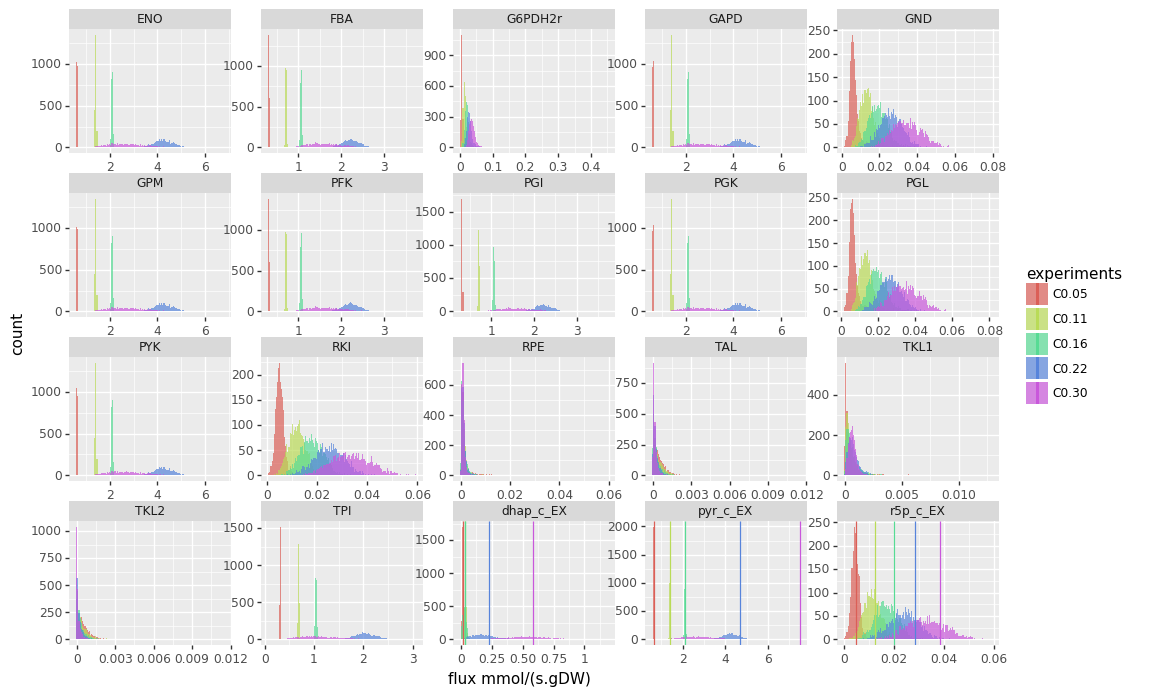

<ggplot: (-9223372036545953662)>


In [18]:
p9.options.figure_size = (12, 8)
p_flux = (
    ggplot(data=posterior_distribution_flux)
    + geom_histogram(aes(x='flux', fill='experiments'), position='identity', alpha=0.7)
    + facet_wrap('~reactions', scales='free')
    + p9.labels.xlab('flux mmol/(s.gDW)')
    + p9.themes.theme(panel_spacing_y=0.2, 
                      panel_spacing_x=0.3)
    + p9.geoms.geom_vline(aes(xintercept='value', color='experiments'), 
                          na_rm=True, 
                          size=0.5, 
                          alpha=1)
)
print(p_flux)
# p_flux.save(filename=os.path.join(PATHS['RESULTS'],'Flux_Distributions.png'), verbose=False)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


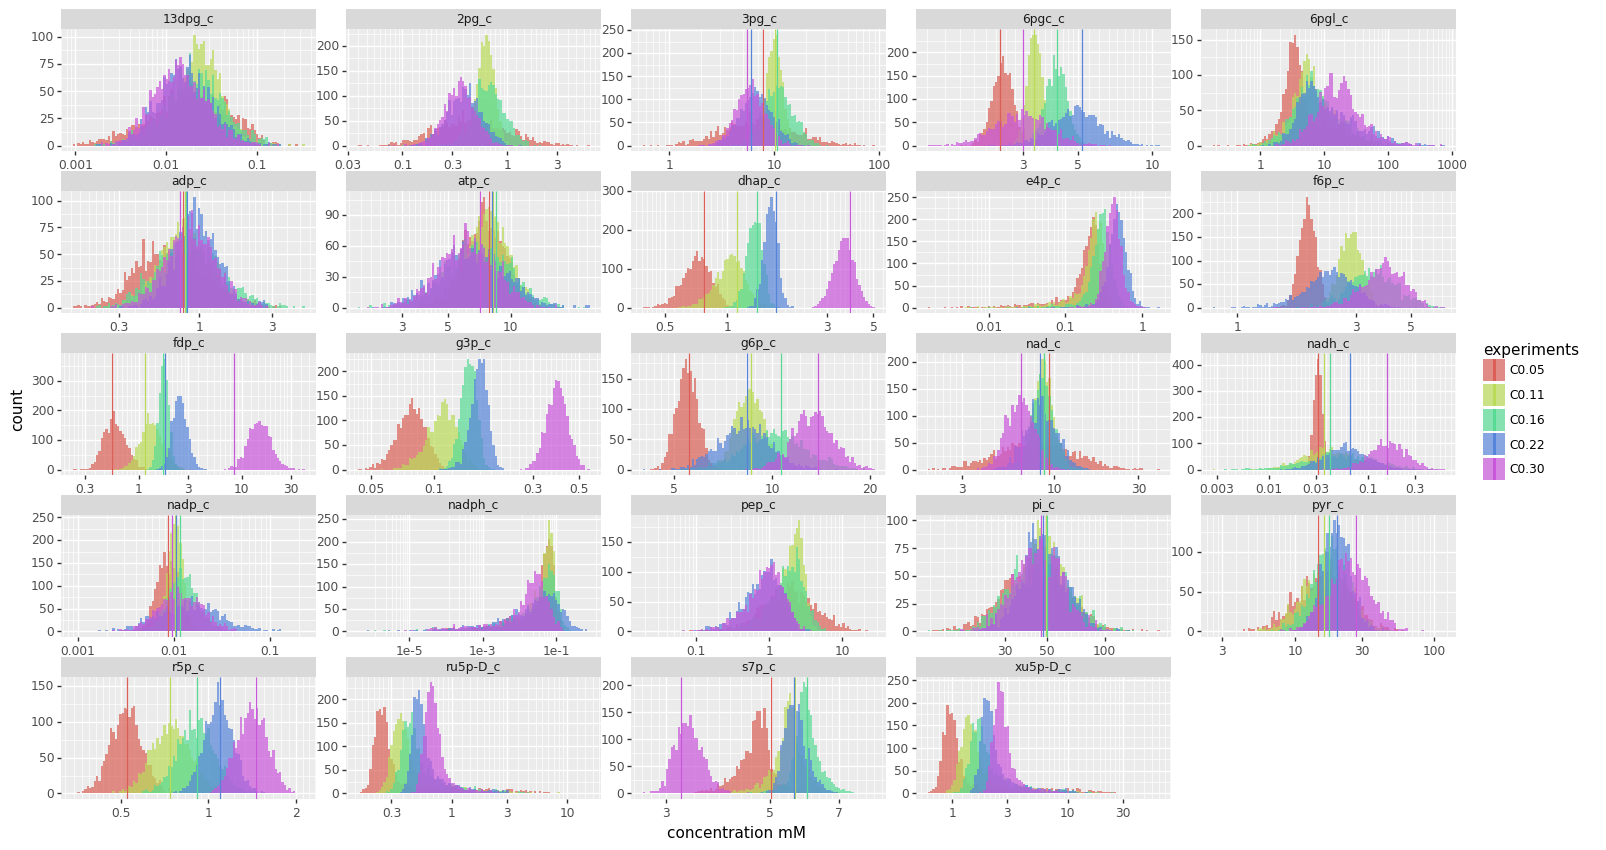

<ggplot: (-9223372036545977491)>


In [20]:
p9.options.figure_size = (18, 10)
p_conc = (
    ggplot(data=posterior_distribution_conc)
    + geom_histogram(aes(x='conc', fill='experiments'), position='identity', alpha=0.7, bins = 100)
    + facet_wrap('~mic', scales = "free")
    + p9.scale_x_continuous(trans='log10')
    + p9.labels.xlab('concentration mM')
    + p9.themes.theme(panel_spacing_y=0.2, 
                      panel_spacing_x=0.3)
    + p9.geoms.geom_vline(aes(xintercept='value', color='experiments'), 
                          na_rm=True, 
                          size=0.5, 
                          alpha=1)
)
print(p_conc)
# p_conc.save(filename=os.path.join(PATHS['RESULTS'],'Conc_Distributions.png'), verbose=False)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


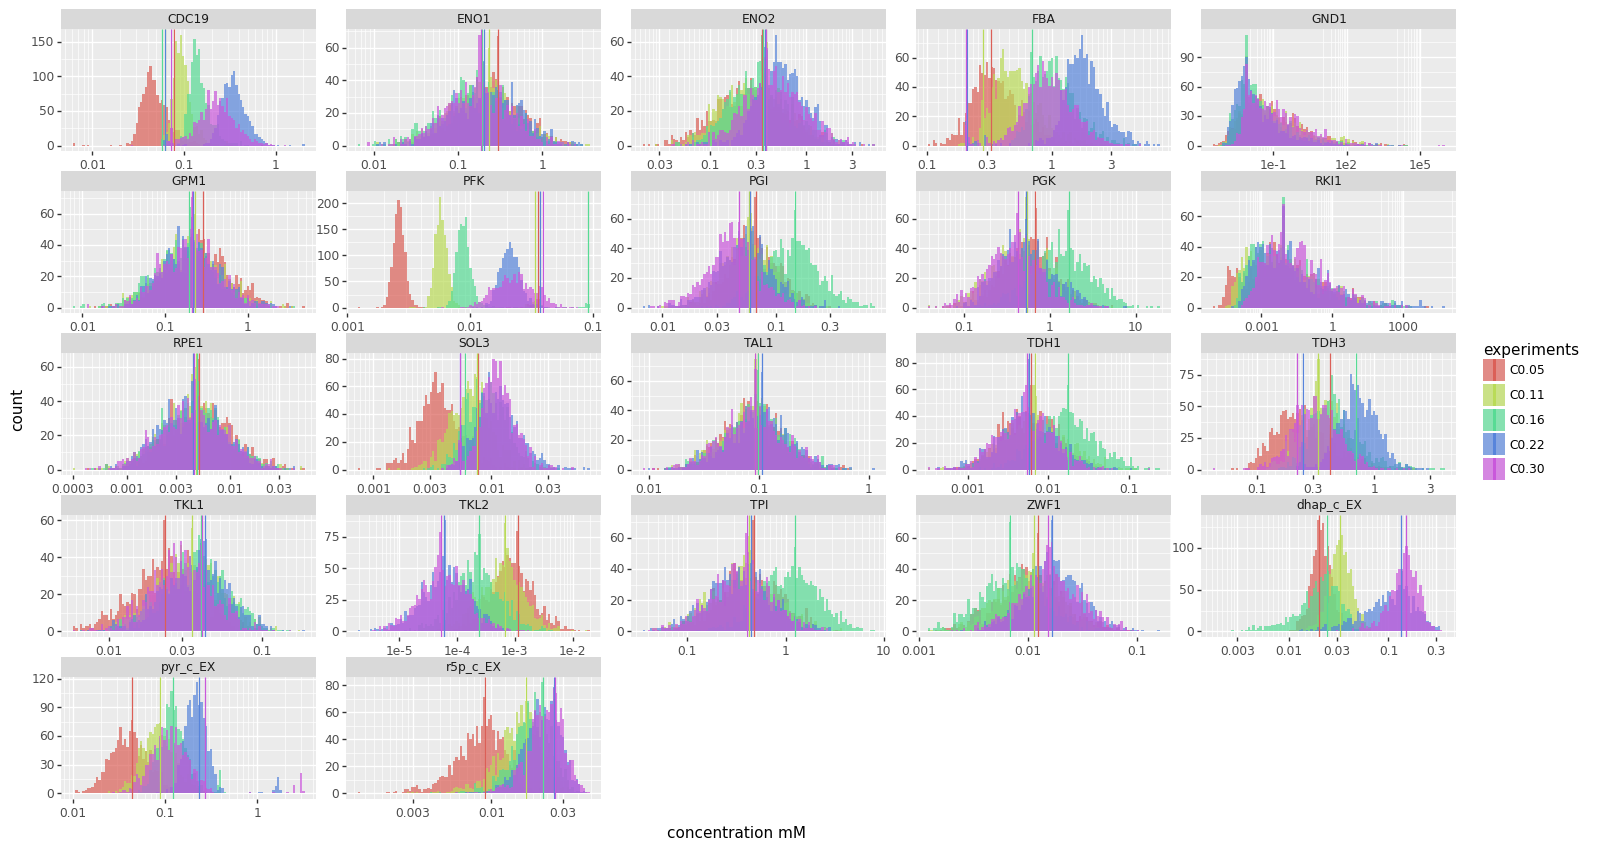

<ggplot: (308055381)>


In [56]:
p9.options.figure_size = (18, 10)
p_conc_enz = (
    ggplot(data=posterior_distribution_enz)
    + geom_histogram(aes(x='enzyme_concentration', fill='experiments'), position='identity', alpha=0.7, bins = 100)
    + facet_wrap('~enzymes', scales = "free")
    + p9.scale_x_continuous(trans='log10')
    + p9.labels.xlab('concentration mM')
    + p9.themes.theme(panel_spacing_y=0.2, 
                      panel_spacing_x=0.3)
    + p9.geoms.geom_vline(aes(xintercept='value', color='experiments'), 
                          na_rm=True, 
                          size=0.5, 
                          alpha=1)
)
print(p_conc_enz)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 139'. Pick better value with 'binwidth'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


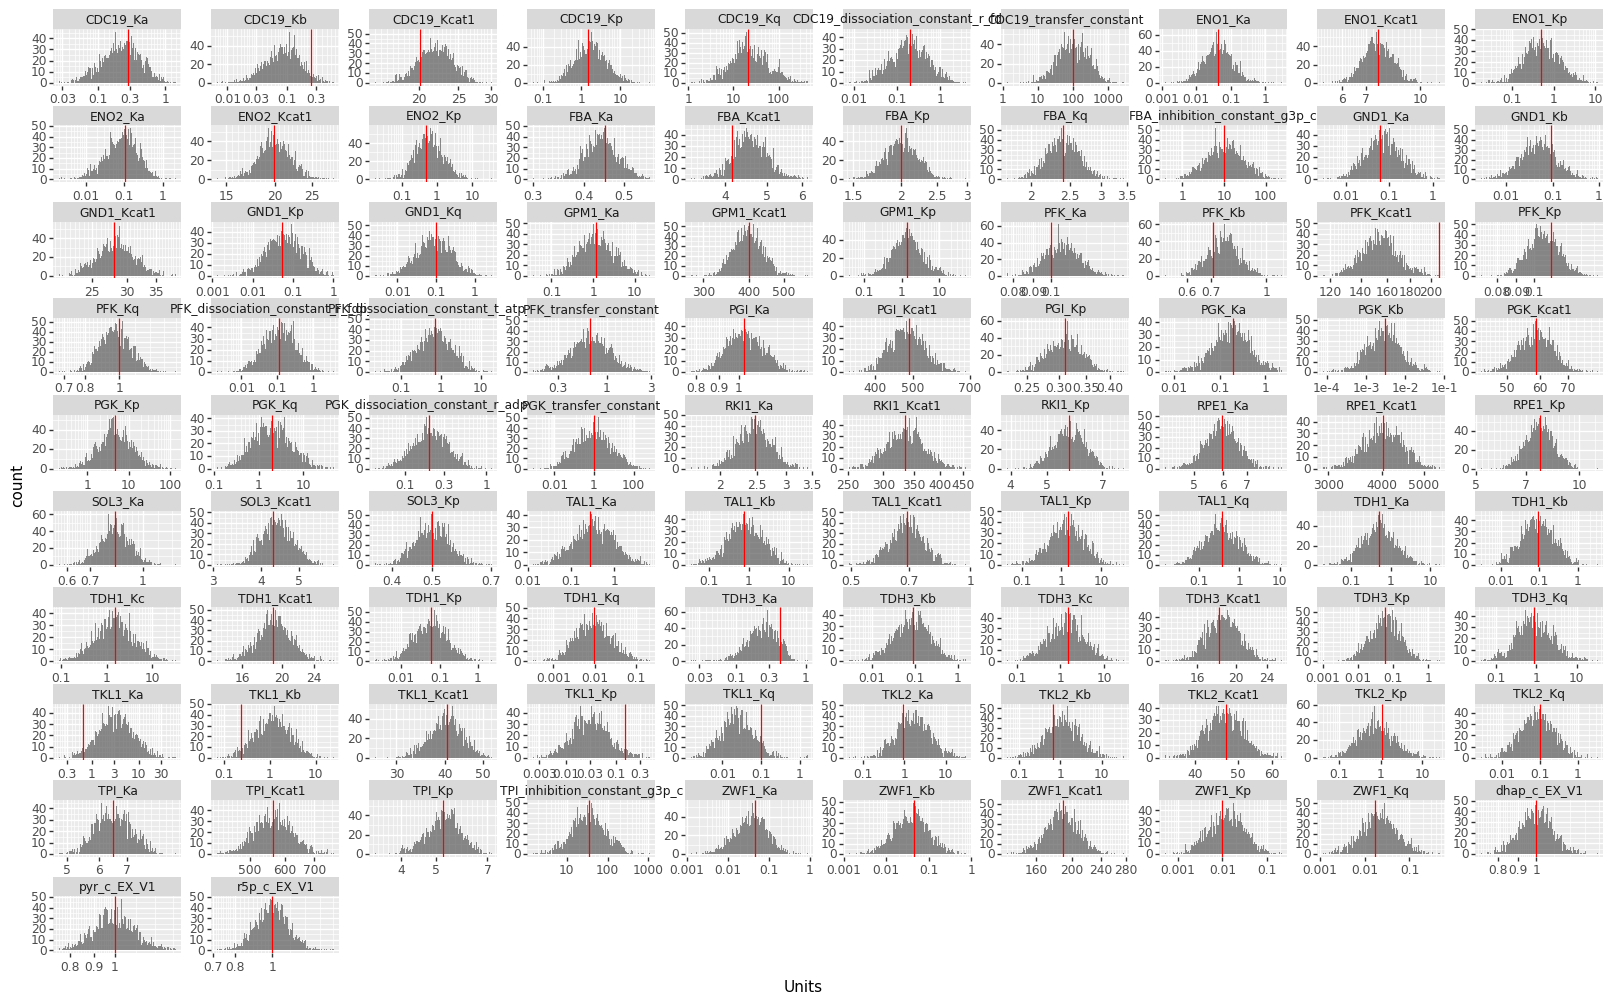

<ggplot: (-9223372036537824014)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 139'. Pick better value with 'binwidth'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


In [21]:
p9.options.figure_size = (20, 12)
p_kp = (
    ggplot(data=posterior_distribution_kp)
    + geom_histogram(aes(x='kinetic_parameters'), position='identity', alpha=0.7)
    + facet_wrap('~parameter_names', scales = "free")
    + p9.scale_x_continuous(trans='log10')
    + p9.labels.xlab('Units')
    + p9.themes.theme(panel_spacing_y=0.2, panel_spacing_x=0.3)
    + p9.geoms.geom_vline(aes(xintercept='ref_val'), 
                      na_rm=True, 
                      size=0.5, 
                      alpha=1,
                      color='red')
)
print(p_kp)
p_kp.save(filename=os.path.join(PATHS['RESULTS'],'Kp Distributions.png'), verbose=False)

In [22]:
posterior_distribution_kp['sample'] = posterior_distribution_kp.apply(lambda row: row.chain*500 + row.draw, axis=1)

In [79]:
p9.options.figure_size = (12, 8)
p_flux = (
    ggplot(data=log_likelihood)
    + geom_histogram(aes(x='log_like', fill='experiments'), position='identity', alpha=0.7)
    + facet_wrap('~measurement_names', scales="free")
    + p9.labels.xlab('log_likelihood')
    + p9.themes.theme(panel_spacing_y=0.2, panel_spacing_x=0.3)
)
print(p_flux)
p_flux.save(filename=os.path.join(PATHS['RESULTS'],'Log_Likelihood.png'), verbose=False)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 13394'. Pick better value with 'binwidth'.


KeyboardInterrupt: 

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


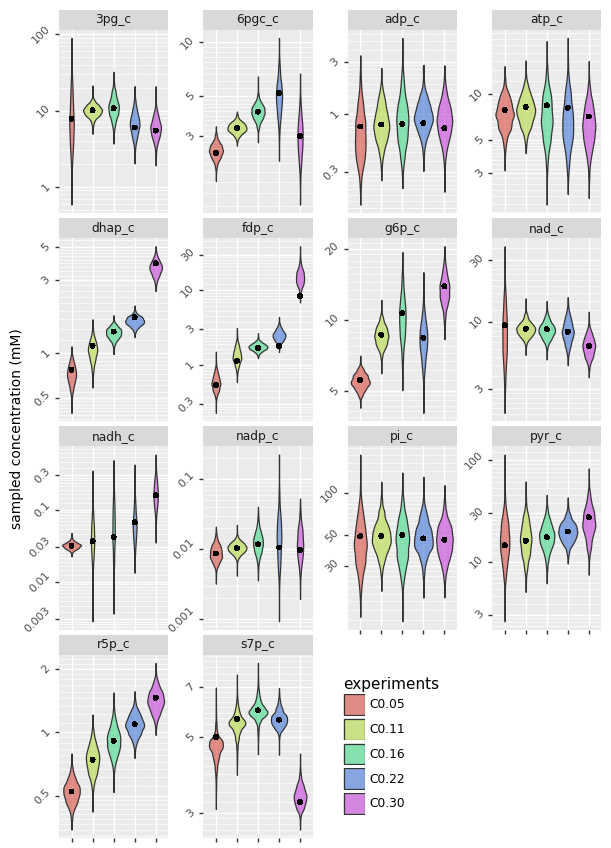

<ggplot: (301205519)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


In [555]:
p9.options.figure_size = (7, 10.5)
p_conc = (
    ggplot(data=posterior_distribution_conc.dropna(axis=0))
    + p9.geom_violin(aes(y='conc', x='experiments', fill='experiments'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='value', x='experiments'), 
                 position='identity',
                 fill='black',
                 size=1)
    + p9.labs(x = 'concentration (mM)',
              y = 'sampled concentration (mM)')
    + facet_wrap('~mic', scales="free_y")
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.35,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      legend_position=(0.6, 0.2)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
    + p9.scale_y_log10()
)
    
print(p_conc)
p_conc.save(filename=os.path.join(PATHS['RESULTS'],'04_within_sample_metabolite_distributions.png'), verbose=False, dpi=300)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 100000 rows containing missing values.


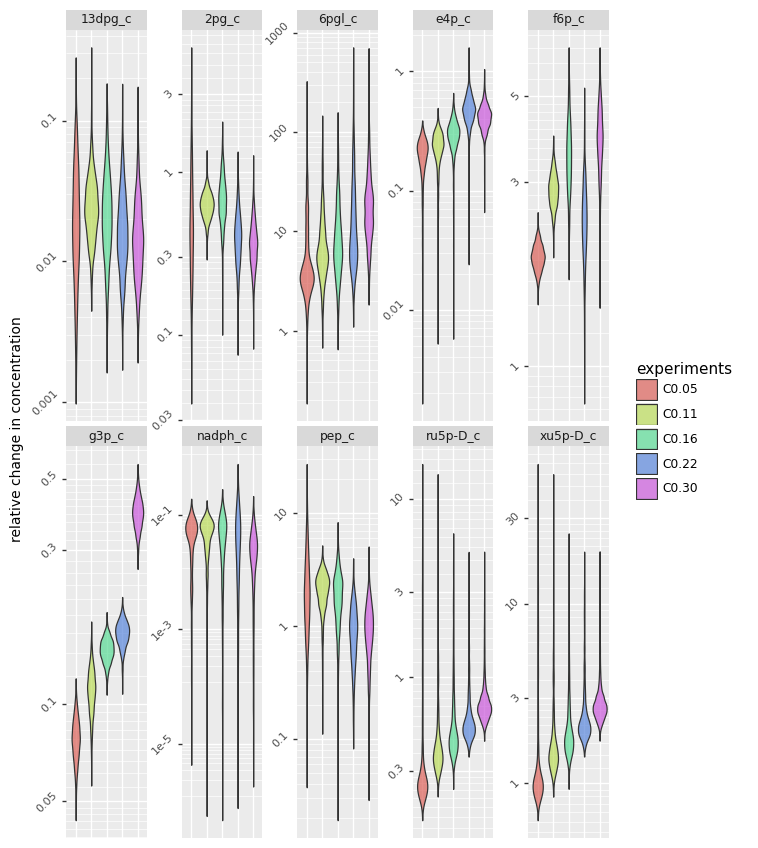

<ggplot: (-9223372036551601706)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 100000 rows containing missing values.


In [568]:
p9.options.figure_size = (7, 10.5)
p_conc_unmeasured = (
    ggplot(data=posterior_distribution_conc[posterior_distribution_conc['value'].isna()])
    + p9.geom_violin(aes(y='conc', x='experiments', fill='experiments'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='value', x='experiments'), 
                 position='identity',
                 fill='black',
                 size=1)
    + p9.labs(x = 'concentration (mM)',
              y = 'relative change in concentration')
    + facet_wrap('~mic', scales="free_y", nrow=2)
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.35,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
    + p9.scale_y_log10()
)
    
print(p_conc_unmeasured)
p_conc_unmeasured.save(filename=os.path.join(PATHS['RESULTS'],'04_within_sample_metabolite_distributions_unmeasured.png'), verbose=False, dpi=300)

In [26]:
relative_met_list = ['13dpg_c', '6pgl_c', 'e4p_c', 'g3p_c', 'pep_c']
posterior_distribution_conc_rel_meas = posterior_distribution_conc[posterior_distribution_conc['mic'].isin(relative_met_list)]
conc_summary = data_trained.posterior.conc.to_dataframe().reset_index()
conc_summary = conc_summary[conc_summary['mic'].isin(relative_met_list)].groupby(['experiments', 'mic']).median().reset_index()
conc_summary = conc_summary.drop(['draw', 'chain'], axis=1)
conc_summary = conc_summary.merge(relative_metabolite_changes)
conc_summary_copy = conc_summary.copy(deep=True)
for exp in experiment_codes:
    for met in relative_met_list:
        tmp_conc = np.array(posterior_distribution_conc_rel_meas[posterior_distribution_conc_rel_meas['experiments'] == exp][posterior_distribution_conc_rel_meas['mic'] == met]['conc'])
        tmp_value = np.float(conc_summary[conc_summary['experiments'] == exp][conc_summary['mic'] == met]['value'])
        ref_value = np.float(conc_summary_copy[conc_summary_copy['experiments'] == 'C0.05'][conc_summary_copy['mic'] == met]['value'])
        ref_conc = np.float(conc_summary_copy[conc_summary_copy['experiments'] == 'C0.05'][conc_summary_copy['mic'] == met]['conc'])
        posterior_distribution_conc_rel_meas.loc[(posterior_distribution_conc_rel_meas['experiments'] == exp) & (posterior_distribution_conc_rel_meas['mic'] == met), 'conc'] = tmp_conc/ref_conc
        posterior_distribution_conc_rel_meas.loc[(posterior_distribution_conc_rel_meas['experiments'] == exp) & (posterior_distribution_conc_rel_meas['mic'] == met), 'value'] = tmp_value/ref_value

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


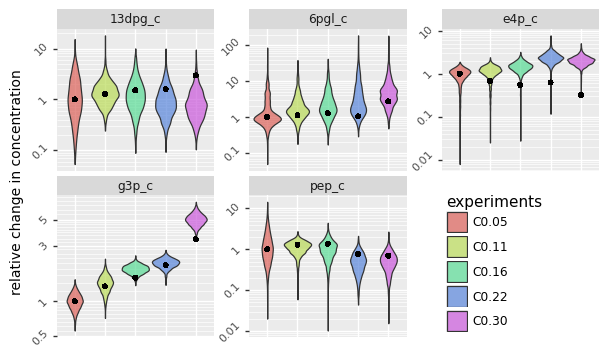

<ggplot: (-9223372036533220222)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


In [27]:
p9.options.figure_size = (7, 4)
p_conc_unmeasured = (
    ggplot(data=posterior_distribution_conc_rel_meas)
    + p9.geom_violin(aes(y='conc', x='experiments', fill='experiments'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='value', x='experiments'), 
                 position='identity',
                 fill='black',
                 size=1)
    + p9.labs(x = 'concentration (mM)',
              y = 'relative change in concentration')
    + facet_wrap('~mic', scales="free_y", nrow=2)
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.35,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position=(0.75, 0.3)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
    + p9.scale_y_log10()
)
    
print(p_conc_unmeasured)
p_conc_unmeasured.save(filename=os.path.join(PATHS['RESULTS'],'conc_distributions_unmeasured.png'), verbose=False, dpi=300)

# Questions about PFK and CDC19 correlations to flux

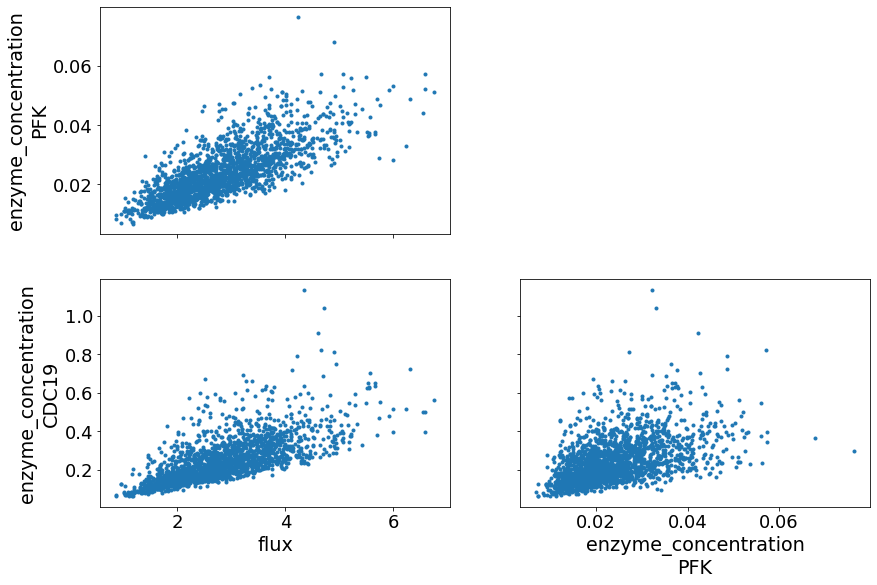

In [33]:
plt.close()
az.plot_pair(data_trained,
             var_names=['flux', 'enzyme_concentration'],
             coords={'reactions': 'pyr_c_EX', 'enzymes': ["PFK", "CDC19"], 'experiments': "C0.30"},
             textsize=18)
plt.savefig(os.path.join(PATHS['RESULTS'], "04_CDC19_PFK_flux_correlation_C0.30.png"), dpi=300)

In [ ]:
az.plot_pair(data_trained,
             var_names=['flux', 'enzyme_concentration'],
             coords={'reactions': 'pyr_c_EX', 'enzymes': ["PFK", "CDC19"], 'experiments': "C0.30"},
             textsize=18)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 20000 rows containing missing values.


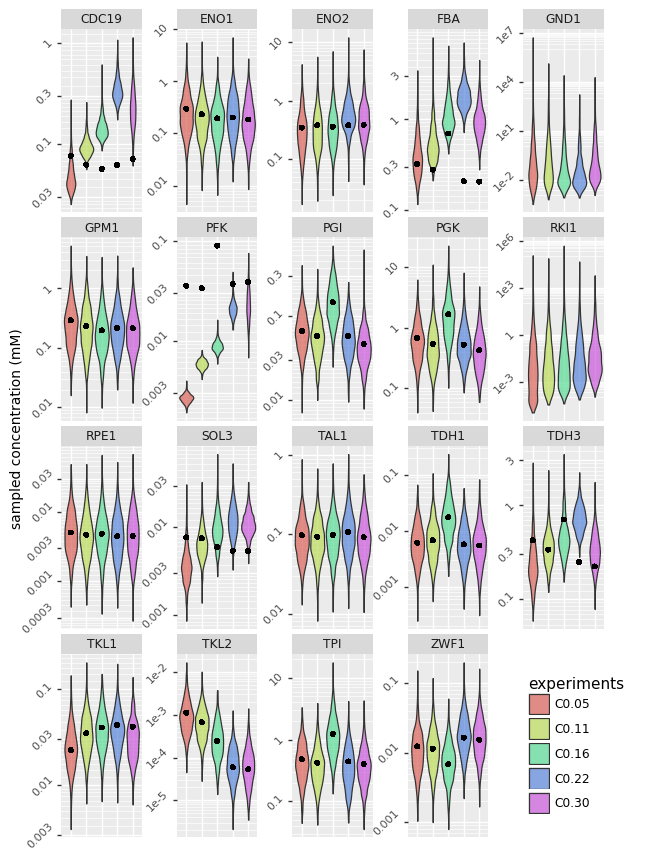

<ggplot: (-9223372036553275704)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 20000 rows containing missing values.


In [563]:
p9.options.figure_size = (7, 10.5)
posterior_distribution_enz_noEX = posterior_distribution_enz[posterior_distribution_enz['enzymes'].apply(lambda x: 'EX' not in x)]
p_enz_conc = (
    ggplot(data=posterior_distribution_enz_noEX)
    + p9.geom_violin(aes(y='enzyme_concentration', x='experiments', fill='experiments'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='value', x='experiments'), 
                 position='identity',
                 fill='black',
                 size=1)
    + p9.labs(x = 'concentration (mM)',
              y = 'sampled concentration (mM)')
    + facet_wrap('~enzymes', scales="free_y")
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.35,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position=(0.86, 0.2)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
    + p9.scale_y_log10()
)
    
print(p_enz_conc)
p_enz_conc.save(filename=os.path.join(PATHS['RESULTS'],'04_within_sample_enzyme_distributions.png'), verbose=False, dpi=300)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


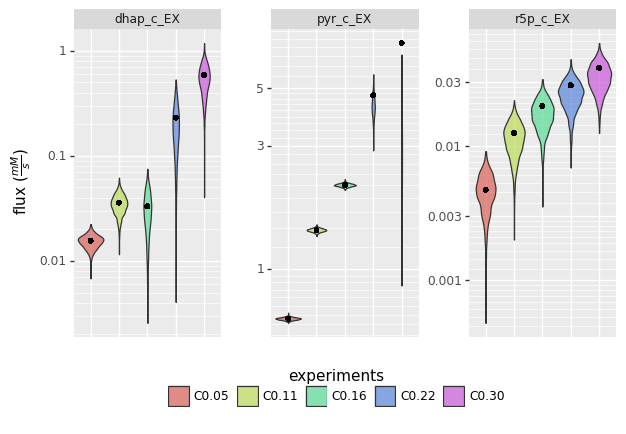

<ggplot: (-9223372036552644015)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


In [560]:
p9.options.figure_size = (7, 4)
p_flux = (
    ggplot(data=posterior_distribution_flux.dropna(axis=0))
    + p9.geom_violin(aes( x='experiments', y='flux', fill='experiments'), 
                 position='identity',
                 alpha=0.7,
                 show_legend=True)
    + geom_point(aes(y='value', x='experiments'), 
                 position='identity',
                 fill='black',
                 size=1)
    + facet_wrap('~reactions', 
                 scales="free_y",
                 ncol=3)
    + p9.labs(y = r'flux ($\frac{mM}{s}$)')
    + p9.themes.theme(panel_spacing_y=0.2, 
                      panel_spacing_x=0.5,
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position='bottom',
                      legend_title_align='center',
)
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
    + p9.scale_y_log10()
)
print(p_flux)
p_flux.save(filename=os.path.join(PATHS['RESULTS'],'04_within_sample_flux_distributions.png'), verbose=False)

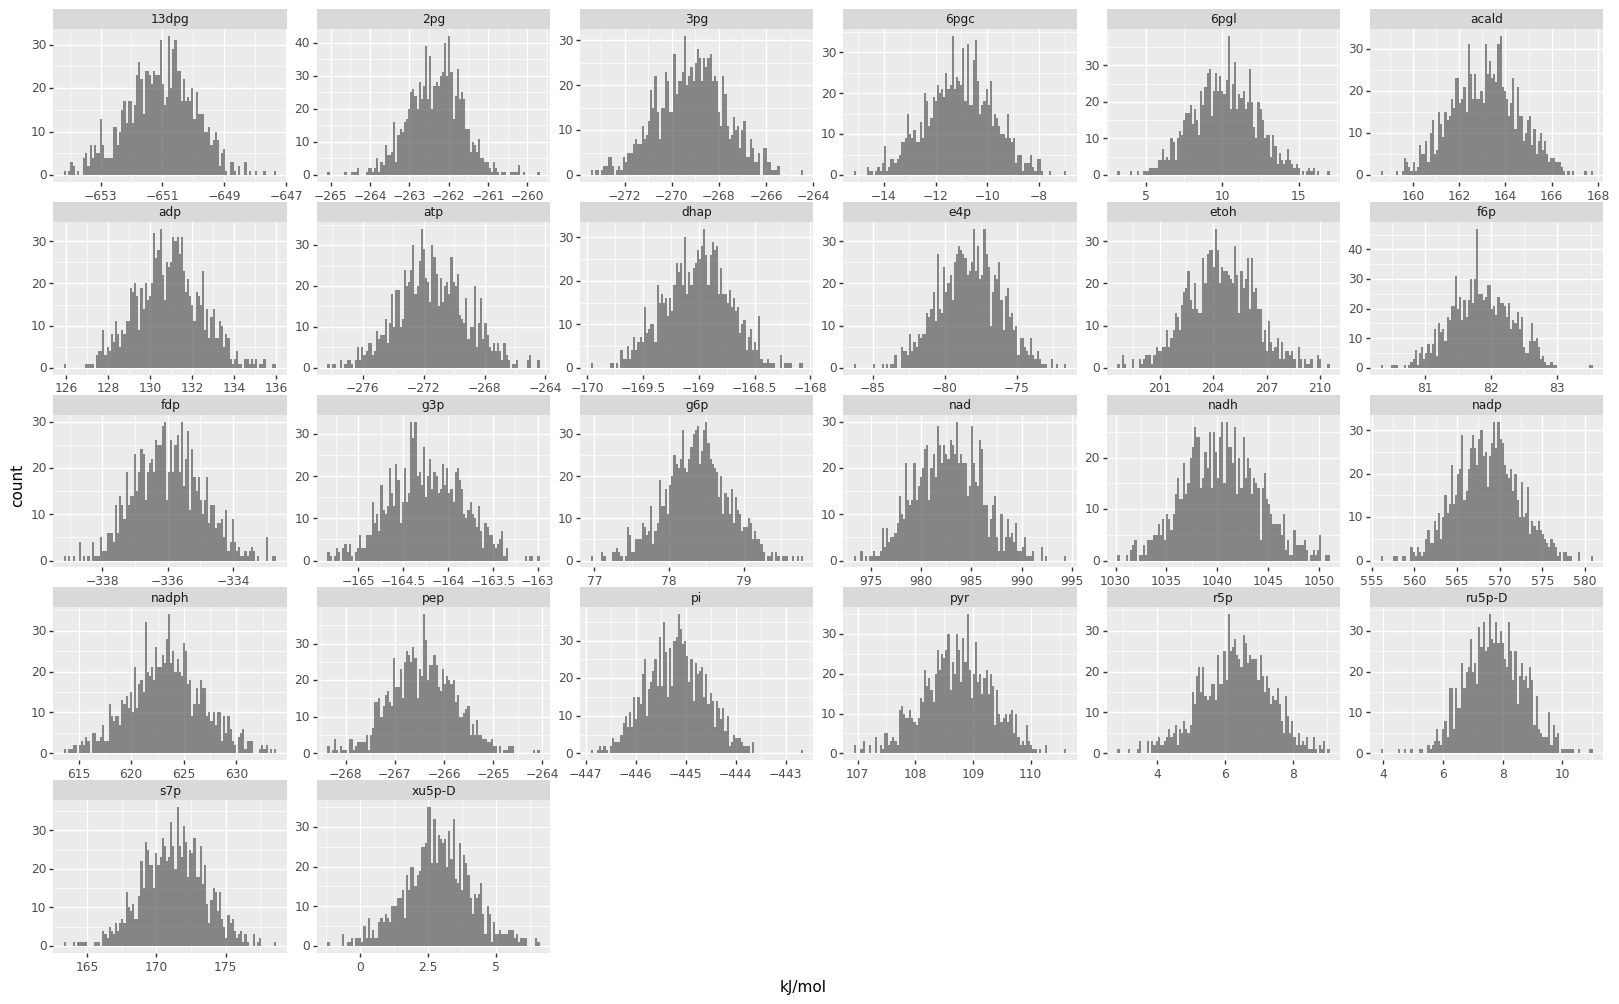

<ggplot: (311744362)>


In [25]:
p9.options.figure_size = (20, 12)
p_dgf = (
    ggplot(data=posterior_distribution_dgf)
    + geom_histogram(aes(x='formation_energy'), position='identity', alpha=0.7, bins=100)
    + facet_wrap('~metabolites', scales="free")
    + p9.labels.xlab('kJ/mol')
    + p9.themes.theme(panel_spacing_y=0.2, 
                  panel_spacing_x=0.3)
    + p9.themes.theme(panel_spacing_y=0.2, panel_spacing_x=0.3)
)
print(p_dgf)
p_dgf.save(filename=os.path.join(PATHS['RESULTS'],'Thermodynamcis_formation.png'), verbose=False)

In [78]:
plt.close('all')
khats = az.loo(data_trained, pointwise=True).pareto_k
fig, ax = plt.subplots(figsize=(20, 10))
az.plot_khat(khats, annotate=True, ax=ax, textsize=16)

fig.suptitle('k_hat Distribution', fontsize=20)
ax.set_xlabel('Variable', fontsize=16)
ax.set_ylabel('k_hat', fontsize=16)

plt.tight_layout()

fig.savefig(os.path.join(PATHS['RESULTS'],'khat_distribution.png'))

TypeError: log likelihood not found in inference data object

In [67]:
kinetic_parameter_sets = pd.pivot(posterior_distribution_kp.drop(['chain', 'draw'], axis=1), columns='parameter_names', index='sample')

In [421]:
pfk_met_tidy = tidy_conc_pulse[tidy_conc_pulse['metabolite_code'].isin(['f6p_c', 'fdp_c'])][tidy_conc_pulse[tidy_conc_pulse['metabolite_code'].isin(['f6p_c', 'fdp_c'])]['experiment_code']=='C0.05']
PFK_tidy_dG = tidy_dG_pulse[tidy_dG_pulse['enzyme_code']=='PFK'][tidy_dG_pulse[tidy_dG_pulse['enzyme_code']=='PFK']['experiment_code']=='C0.05']
PFK_tidy_flux = tidy_flux_pulse[tidy_flux_pulse['reaction_code']=='PFK'][tidy_flux_pulse[tidy_flux_pulse['reaction_code']=='PFK']['experiment_code']=='C0.05']
PFK_tidy_allo = tidy_reg_pulse[tidy_reg_pulse['enzyme_code']=='PFK'][tidy_reg_pulse[tidy_reg_pulse['enzyme_code']=='PFK']['experiment_code']=='C0.05']

In [180]:
tidy_dG_pulse

,experiment_code,enzyme_code,dG_run,variable,value
0,C0.30,r5p_c_EX,100,0.001,-116.485878
1,C0.30,r5p_c_EX,200,0.001,-116.482566
2,C0.30,r5p_c_EX,300,0.001,-116.405880
3,C0.30,r5p_c_EX,400,0.001,-116.191703
4,C0.30,r5p_c_EX,500,0.001,-116.869598
...,...,...,...,...,...
1595,C0.30,r5p_c_EX,19600,10000.000,-117.142811
1596,C0.30,r5p_c_EX,19700,10000.000,-117.721439
1597,C0.30,r5p_c_EX,19800,10000.000,-118.382884
1598,C0.30,r5p_c_EX,19900,10000.000,-116.278420


In [53]:
p9.options.figure_size = (6, 4)
p_conc_ode = (
    ggplot(data=zwf_met_tidy)
    + p9.geom_line(aes( x='variable', y='value', group='met_run'), 
                 position='identity',
                 alpha=0.5,
                 show_legend=False)
    + p9.labs(x = 'time (s)',
              y = 'concentration (mM)')
    + facet_wrap('~metabolite_code', scales="free")
#     + p9.themes.theme(panel_spacing_y=0.2, 
#                       panel_spacing_x=0.5,
#                       axis_title=p9.element_text(size=14),
#                       axis_text=p9.element_text(size=12))
)
print(p_conc_ode)

NameError: name 'zwf_met_tidy' is not defined

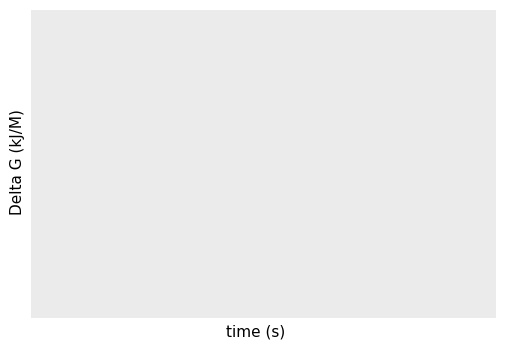

<ggplot: (-9223372036544702937)>


In [179]:
p9.options.figure_size = (6, 4)
p_conc_ode = (
    ggplot(data=PFK_tidy_dG)
    + p9.geom_line(aes( x='variable', y='value', group='dG_run'), 
                 position='identity',
                 alpha=0.5,
                 show_legend=False)
    + p9.labs(x = 'time (s)',
              y = 'Delta G (kJ/M)')
#    + facet_wrap('~experiment_code', scales="free")
#     + p9.themes.theme(panel_spacing_y=0.2, 
#                       panel_spacing_x=0.5,
#                       axis_title=p9.element_text(size=14),
#                       axis_text=p9.element_text(size=12))
)
print(p_conc_ode)

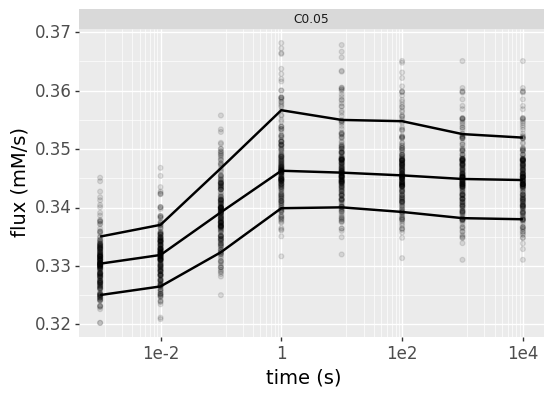

<ggplot: (310126810)>


In [182]:
p9.options.figure_size = (6, 4)
p_flux_ode = (
    ggplot(PFK_tidy_flux, aes( x='variable', y='value'))
    + p9.scale_x_log10()
    + p9.geom_point(alpha = 0.1)
    +p9.geom_smooth(aes(x='variable', y='value'), 
                     data = PFK_tidy_flux[['variable', 'value']].groupby('variable').quantile(0.5).reset_index(), 
                     span=0.4,
                     se=False,
                     method='lowess')
    + p9.geom_smooth(aes(x='variable', y='value'), 
                     data = PFK_tidy_flux[['variable', 'value']].groupby('variable').quantile(0.1).reset_index(), 
                     span=0.4,
                     se=False,
                     method='lowess')
    + p9.geom_smooth(aes(x='variable', y='value'), 
                     data = PFK_tidy_flux[['variable', 'value']].groupby('variable').quantile(0.9).reset_index(), 
                     span=0.4,
                     se=False,
                     method='lowess')
    + p9.labs(x = 'time (s)',
              y = 'flux (mM/s)')
   + facet_wrap('~experiment_code', scales="free")
    + p9.themes.theme(panel_spacing_y=0.2, 
                      panel_spacing_x=0.5,
                      axis_title=p9.element_text(size=14),
                      axis_text=p9.element_text(size=12))
)
print(p_flux_ode)

In [181]:
pfk_flux_sum = pd.DataFrame(index=PFK_tidy_flux['variable'].unique(), columns=['median', '0.1', '0.9']).reset_index()
pfk_flux_sum['median'] =pfk_met_tidy[['variable', 'value']].groupby('variable').quantile(0.5).values
pfk_flux_sum['0.1'] = pfk_met_tidy[['variable', 'value']].groupby('variable').quantile(0.1).values
pfk_flux_sum['0.9'] = pfk_met_tidy[['variable', 'value']].groupby('variable').quantile(0.9).values

pfk_reg_sum = pd.DataFrame(index=PFK_tidy_allo['variable'].unique(), columns=['median', '0.1', '0.9']).reset_index()
pfk_reg_sum['median'] = PFK_tidy_allo[['variable', 'value']].groupby('variable').quantile(0.5).values
pfk_reg_sum['0.1'] = PFK_tidy_allo[['variable', 'value']].groupby('variable').quantile(0.1).values
pfk_reg_sum['0.9'] = PFK_tidy_allo[['variable', 'value']].groupby('variable').quantile(0.9).values

In [425]:
pfk_flux_sum

,index,median,0.1,0.9
0,0.0001,0.026059,0.014816,0.045365
1,0.0010,0.027436,0.015351,0.049332
2,0.0100,0.032799,0.016284,0.069872
3,0.1000,0.036481,0.018942,0.084597
4,1.0000,0.045289,0.026557,0.085471
5,10.0000,0.048303,0.027081,0.087003
6,100.0000,0.048311,0.027088,0.087008
7,1000.0000,0.048311,0.027088,0.087008


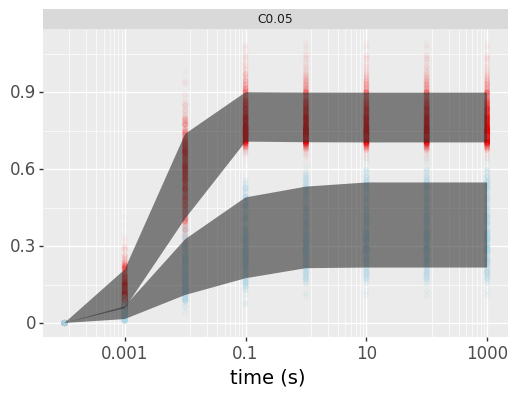

<ggplot: (318602132)>


In [417]:
p9.options.figure_size = (6, 4)
p_flux_ode = (
    ggplot(PFK_tidy_flux, aes( x='variable', y='value'))
    + p9.scale_x_log10()
    + p9.geom_point(alpha = 0.01,
                   color = 'red')
    + p9.geom_point(aes(x='variable', y='value'), 
                    data = PFK_tidy_allo,
                    alpha = 0.1,
                    color = 'lightblue',
                   )
    + p9.geom_ribbon(aes(x='index', y='median', ymin='0.1', ymax='0.9'), 
                    data = pfk_flux_sum, 
                    alpha = 0.6)
    + p9.geom_ribbon(aes(x='index', y='median', ymin='0.1', ymax='0.9'), 
                    data = pfk_reg_sum, 
                    alpha = 0.6)
    + p9.labs(x = 'time (s)',
              y = '')
    + facet_wrap('~experiment_code', scales="free")
    + p9.themes.theme(panel_spacing_y=0.2, 
                      panel_spacing_x=0.5,
                      axis_title=p9.element_text(size=14),
                      axis_text=p9.element_text(size=12))
)
print(p_flux_ode)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


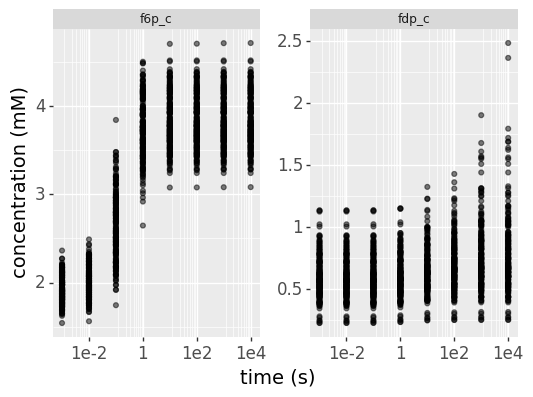

<ggplot: (310122767)>


In [183]:
p9.options.figure_size = (6, 4)
p_reg_ode = (
    ggplot(data=pfk_met_tidy)
    + p9.scale_x_log10()
    + p9.geom_point(aes( x='variable', y='value'), 
                 position='identity',
                 alpha=0.5,
                 show_legend=False)
    + p9.labs(x = 'time (s)',
              y = 'concentration (mM)')
    + facet_wrap('~metabolite_code', scales="free")
    + p9.themes.theme(panel_spacing_y=0.2, 
                      panel_spacing_x=0.5,
                      axis_title=p9.element_text(size=14),
                      axis_text=p9.element_text(size=12))
)
print(p_reg_ode)

In [408]:
PFK_tidy_flux['value'] = PFK_tidy_flux['value'].apply(np.log)
PFK_tidy_allo['value'] = PFK_tidy_allo['value'].apply(np.log)

In [47]:
exchange_fluxes_validation = tidy_flux_pulse[tidy_flux_pulse["variable"]==1000][tidy_flux_pulse['reaction_code'].isin(["pyr_c_EX", "dhap_c_EX", "r5p_c_EX"])].reset_index(drop=True)

NameError: name 'tidy_flux_pulse' is not defined

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


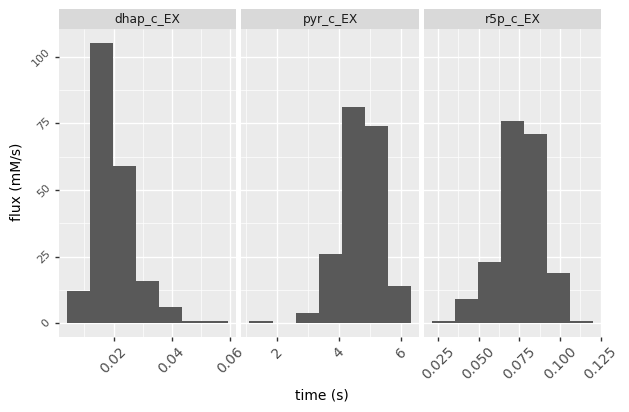

<ggplot: (-9223372036539330865)>


In [113]:
p9.options.figure_size = (7, 4)
p_flux_ode = (
    ggplot(exchange_fluxes_validation, aes( x='value'))
    + p9.geom_histogram()
    + p9.labs(x = 'time (s)',
              y = 'flux (mM/s)')
   + facet_wrap('~reaction_code', scales="free_x")
   + p9.themes.theme(panel_spacing_y=0.2, 
                      panel_spacing_x=0.05,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_x=p9.element_text(size=10, angle = 45),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                     )
)
print(p_flux_ode)

In [117]:
conc_distributions

,met_run,experiment_code,metabolite_code,0.0001,0.001,0.01,0.1,1,10,100,1000,10000
0,0,Validation,atp_c,2.170000,2.170000,2.170000,2.170000,2.170000,2.170000,2.170000,2.170000,2.170000
1,1,Validation,adp_c,2.530000,2.530000,2.530000,2.530000,2.530000,2.530000,2.530000,2.530000,2.530000
2,2,Validation,nad_c,1.470000,1.470000,1.470000,1.470000,1.470000,1.470000,1.470000,1.470000,1.470000
3,3,Validation,nadh_c,0.116000,0.116000,0.116000,0.116000,0.116000,0.116000,0.116000,0.116000,0.116000
4,4,Validation,nadp_c,0.166000,0.166000,0.166000,0.166000,0.166000,0.166000,0.166000,0.166000,0.166000
...,...,...,...,...,...,...,...,...,...,...,...,...
4795,4795,Validation,ru5p-D_c,0.037858,0.037489,0.034381,0.027287,0.034888,0.049136,0.052333,0.052356,0.052356
4796,4796,Validation,r5p_c,0.093989,0.093889,0.092823,0.080605,0.056423,0.080525,0.086352,0.086398,0.086398
4797,4797,Validation,e4p_c,0.013000,0.013000,0.013020,0.013265,0.013893,0.008591,0.010202,0.010242,0.010242
4798,4798,Validation,xu5p-D_c,0.053953,0.054429,0.058707,0.080018,0.131063,0.190344,0.203139,0.203230,0.203230


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 35'. Pick better value with 'binwidth'.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


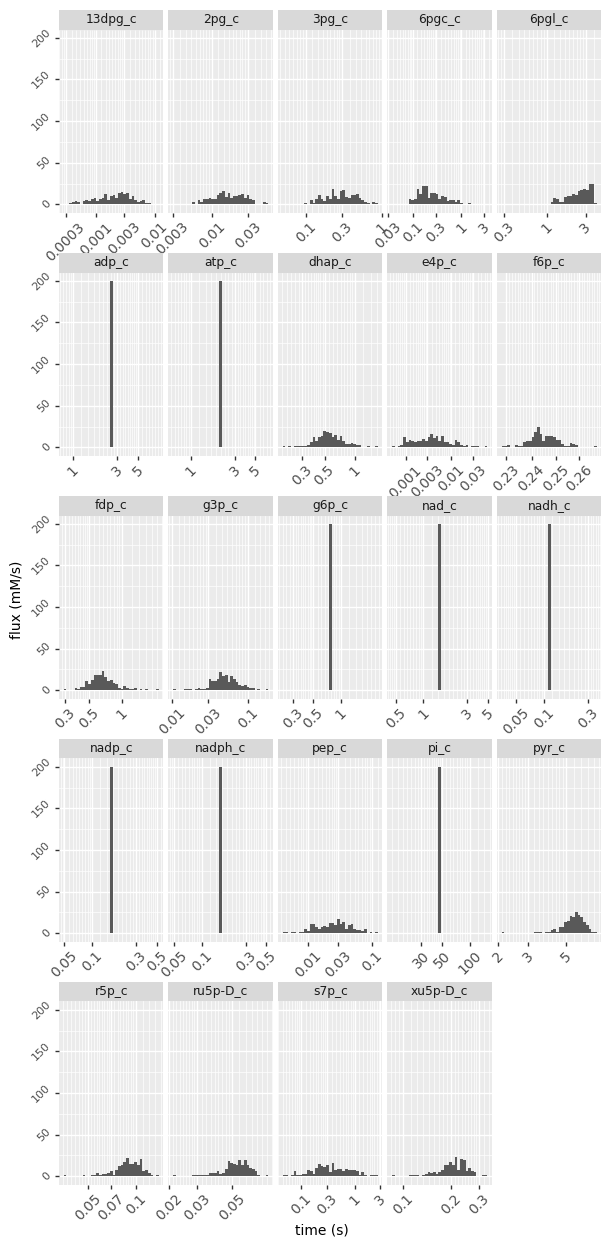

<ggplot: (320915527)>


In [123]:
p9.options.figure_size = (7, 15)
p_conc_ode = (
    ggplot(tidy_conc_pulse[tidy_conc_pulse["variable"]==10000], aes( x='value'))
    + p9.geom_histogram()
    + p9.scale_x_log10()
    + p9.labs(x = 'time (s)',
              y = 'flux (mM/s)')
   + facet_wrap('~metabolite_code', scales="free_x")
   + p9.themes.theme(panel_spacing_y=0.4, 
                      panel_spacing_x=0.05,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_x=p9.element_text(size=10, angle = 45),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                     )
)
print(p_conc_ode)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


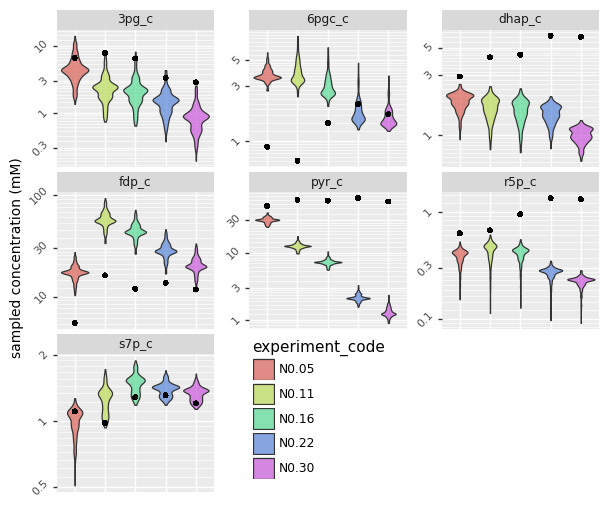

<ggplot: (301995819)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


In [561]:
p9.options.figure_size = (7, 6)
p_conc_val = (
    ggplot(data=tidy_conc_pulse_val_meas[tidy_conc_pulse_val_meas["variable"]==1000][tidy_conc_pulse_val_meas['metabolite_code'].isin(list(balanced_mic_codes))])
    + p9.geom_violin(aes(y='conc', x='experiment_code', fill='experiment_code'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='value', x='experiment_code'), 
                 position='identity',
                 fill='black',
                 size=1)
    + p9.labs(x = 'concentration (mM)',
              y = 'sampled concentration (mM)')
    + facet_wrap('~metabolite_code', scales="free_y")
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.35,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position=(0.5, 0.25)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
    + p9.scale_y_log10()
)
    
print(p_conc_val)
p_conc_val.save(filename=os.path.join(PATHS['RESULTS'],'04_validation_concentration_distributions.png'), verbose=False)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


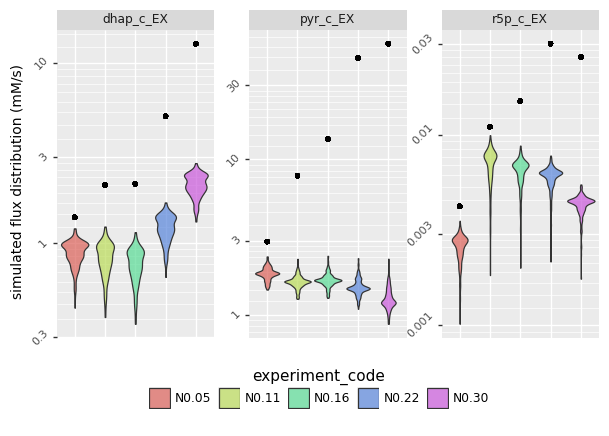

<ggplot: (-9223372036550600153)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


In [562]:
p9.options.figure_size = (7, 4)
exchange_fluxes_validation = tidy_flux_pulse_val_meas[tidy_flux_pulse_val_meas["variable"]==1000]
p_flux_val = (
    ggplot(data=exchange_fluxes_validation)
    + p9.geom_violin(aes(y='flux', x='experiment_code', fill='experiment_code'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='value', x='experiment_code'), 
                 position='identity',
                 fill='black',
                 size=1)
    + p9.labs(x = 'concentration (mM)',
              y = 'simulated flux distribution (mM/s)')
    + facet_wrap('~reaction_code', scales="free_y", ncol=3)
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.35,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position='bottom',
                      legend_title_align='center',
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
    + p9.scale_y_log10()
)
    
print(p_flux_val)
p_flux_val.save(filename=os.path.join(PATHS['RESULTS'],'04_validation_flux_distributions.png'), verbose=False)

In [70]:
kp_enzyme_mapping = pd.DataFrame(columns = ['enzyme_code', 'substrate_codes', 'product_codes'], dtype=object)
idx = 0

substrate_keys = ['Ka', 'Kb', 'Kc']
product_keys = ['Kp', 'Kq', 'Kr']
for enz_id, enz in utils.codify(enzyme_codes).items():
    tmp_kp_list = [x for x in kinetic_parameter_codes if enz_id in x]
    substrate_idx = []
    product_idx = []
    for kp in tmp_kp_list:
        for sub_key in substrate_keys:
            if sub_key in kp[-3:]:
                substrate_idx.append(mi.stan_codes["kinetic_parameter"][kp])
        for prod_key in product_keys:
            if prod_key in kp[-3:]:
                product_idx.append(mi.stan_codes["kinetic_parameter"][kp])
    
    kp_enzyme_mapping.at[idx, 'enzyme_code'] = enz_id
    kp_enzyme_mapping.at[idx, 'substrate_codes'] = substrate_idx
    kp_enzyme_mapping.at[idx, 'product_codes'] = product_idx
    idx += 1

In [136]:
posterior_distribution_enz

,chain,draw,experiments,enzymes,enzyme_concentration,value
0,0,0,C0.05,PGI,0.070691,0.066912
1,0,0,C0.05,PFK,0.002415,0.035730
2,0,0,C0.05,FBA,0.372635,0.322179
3,0,0,C0.05,TPI,1.057280,0.481440
4,0,0,C0.05,TDH1,0.003690,0.006107
...,...,...,...,...,...,...
219995,3,499,C0.30,TKL2,0.000171,0.000053
219996,3,499,C0.30,TAL1,0.092085,0.092097
219997,3,499,C0.30,pyr_c_EX,0.054635,0.271875
219998,3,499,C0.30,dhap_c_EX,0.188834,0.151000


# Regulation Analysis

In [437]:
enzyme_fluxes = pd.read_csv(os.path.join(PATHS['RESULTS'], "yeast_ethanol_fx_no_split_compartment_enzyme_flux_results.csv"))
enzyme_denom = pd.read_csv(os.path.join(PATHS['RESULTS'], "yeast_ethanol_fx_no_split_compartment_enzyme_denom_results.csv"))

In [441]:
regulation_results = pd.DataFrame(columns = ['experiment_code', 'enzyme_code', 'dG', 'draw', 'saturation', 'enzyme_concentration', 'thermodynamic', 'flux'])
idr = 0
draw = 0
full_stoic = sampling.get_full_stoichiometry(mi.kinetic_model, enzyme_codes, mic_codes)
product_list = full_stoic.reset_index().melt(id_vars='index').query('value == 1')
substrate_list = full_stoic.reset_index().melt(id_vars='index').query('value == -1')

for chain in range(0, 4):
    for draw in range(0, 50):
        tmp_draw = posterior_distribution_conc[(posterior_distribution_conc['chain']==chain) & (posterior_distribution_conc['draw']==draw)]
        tmp_dG0 = posterior_distribution_dg[(posterior_distribution_dg['chain']==chain) & (posterior_distribution_dg['draw']==draw)]['delta_g']
        tmp_kp = list(posterior_distribution_kp[(posterior_distribution_kp['chain']==chain) & (posterior_distribution_kp['draw']==draw)]['kinetic_parameters'])
        tmp_enz = posterior_distribution_enz[(posterior_distribution_enz['chain']==chain) & (posterior_distribution_enz['draw']==draw)]
        for exp_id, exp in utils.codify(experiment_codes).items():
            tmp_conc_vector = list(tmp_draw[tmp_draw['experiments']==exp_id]['conc'])
            tmp_enz_conc = list(tmp_enz[tmp_enz['experiments']==exp_id]['enzyme_concentration'])
            tmp_lnQ = np.multiply(298.15*0.008314, np.matmul(full_stoic.values, np.log(tmp_conc_vector)))
            tmp_dG = tmp_dG0.values + tmp_lnQ
            for enz_id, enz in utils.codify(enzyme_codes).items():
                tmp_kp_enz = kp_enzyme_mapping[kp_enzyme_mapping['enzyme_code']==enz_id]
                tmp_kp_prod = 1
                tmp_kp_sub = 1
                for kp_prod in list(tmp_kp_enz['product_codes']):
                    for kp in kp_prod:
                        if kp:
                            tmp_kp_prod *= tmp_kp[kp-1]
                for kp_sub in list(tmp_kp_enz['substrate_codes']):
                    for kp in kp_sub:
                        if kp:
                            tmp_kp_sub *= tmp_kp[kp-1]
                            
                tmp_sub_sat = 1
                tmp_prod_sat = 1
                for prod in product_list[product_list['index']==enz_id]['variable']:
                    tmp_prod_sat *= tmp_conc_vector[mi.stan_codes["metabolite_in_compartment"][prod]-1]
                    
                for sub in substrate_list[substrate_list['index']==enz_id]['variable']:
                    tmp_sub_sat *= tmp_conc_vector[mi.stan_codes["metabolite_in_compartment"][sub]-1]
                    
                tmp_denom = float(enzyme_denom[(enzyme_denom['draw']==draw) & (enzyme_denom['enzyme_code']==enz_id) & (enzyme_denom['experiment_code']==exp_id)]['denom'])
                tmp_saturation = (tmp_sub_sat/tmp_kp_sub)/tmp_denom
                tmp_thermodynamic = 1 - np.exp(tmp_dG[enz-1]/(298.15*0.008314))
                
                regulation_results.loc[idr, 'experiment_code'] = exp_id
                regulation_results.loc[idr, 'enzyme_code'] = enz_id
                regulation_results.loc[idr, 'dG'] = tmp_dG[enz-1]
                regulation_results.loc[idr, 'draw'] = draw+chain*50
                regulation_results.loc[idr, 'saturation'] = tmp_saturation
                regulation_results.loc[idr, 'thermodynamic'] = tmp_thermodynamic
                regulation_results.loc[idr, 'enzyme_concentration'] = tmp_enz_conc[enz-1]
                regulation_results.loc[idr, 'flux'] = float(enzyme_fluxes[(enzyme_fluxes['draw']==draw) & (enzyme_fluxes['enzyme_code']==enz_id) & (enzyme_fluxes['experiment_code']==exp_id)]['flux'])
                idr +=1

In [505]:
tmp_dG

,experiment_code,enzyme_code,dG,draw,saturation,enzyme_concentration,thermodynamic,flux,log_saturation,log_enzyme,log_thermodynamic,unaccounted_change
0,C0.05,PGI,-0.0565637,0,0.41074,0.0706915,0.0225604,0.325273,NaN,NaN,NaN,NaN
1,C0.05,PFK,-25.8508,0,0.867447,0.00241471,0.99997,0.326141,NaN,NaN,NaN,NaN
2,C0.05,FBA,-1.44997,0,0.402198,0.372635,0.442864,0.326141,NaN,NaN,NaN,NaN
3,C0.05,TPI,-0.0170823,0,0.0779625,1.05728,0.0068676,0.310685,NaN,NaN,NaN,NaN
4,C0.05,TDH1,-6.05065,0,0.0843278,0.00368958,0.912921,0.00522542,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
21992,C0.30,RPE1,-0.000638749,199,0.0849729,0.00653368,0.00025765,0.000627006,-4.184279,-4.472998,8.895722,0.761555
21993,C0.30,RKI1,-0.000110874,199,0.210468,10.6969,4.47276e-05,0.0268513,0.314801,4.118430,-3.573848,0.140617
21994,C0.30,TKL1,-6.73315,199,2.20291e-05,0.0694995,0.933879,0.000195464,1.139487,1.132290,0.080267,-1.352045
21995,C0.30,TKL2,-9.5674,199,0.0430075,0.000188244,0.978925,0.000376736,-2.388797,7.514351,0.025743,-4.151297


In [449]:
idx = 0
for draw in regulation_results['draw'].unique():
    tmp_draw = regulation_results[regulation_results['draw']==draw]
    for exp in experiment_codes:
        tmp_exp = tmp_draw[tmp_draw['experiment_code']==exp]
        ref_exp = tmp_draw[tmp_draw['experiment_code']=="C0.05"]
        for enz in enzyme_codes:
            tmp_enz = tmp_exp[tmp_exp['enzyme_code']==enz]
            ref_enz = ref_exp[ref_exp['enzyme_code']==enz]
            flux_change = np.log(float(tmp_enz['flux'])) - np.log(float(ref_enz['flux']))
            saturation_change = np.log(float(tmp_enz['saturation'])) - np.log(float(ref_enz['saturation']))
            regulation_results.loc[idx, 'log_saturation'] = saturation_change/flux_change
            enzyme_change = np.log(float(tmp_enz['enzyme_concentration'])) - np.log(float(ref_enz['enzyme_concentration']))
            regulation_results.loc[idx, 'log_enzyme'] = enzyme_change/flux_change
            thermodynamic_change = np.log(float(tmp_enz['thermodynamic'])) - np.log(float(ref_enz['thermodynamic']))
            regulation_results.loc[idx, 'log_thermodynamic'] = thermodynamic_change/flux_change
            regulation_results.loc[idx, 'unaccounted_change'] = 1 - thermodynamic_change/flux_change - enzyme_change/flux_change - saturation_change/flux_change
            
            idx += 1 

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log


In [545]:
upper_dG = tmp_dG.groupby(['enzyme_code', 'experiment_code'])['dG'].quantile(0.9)
upper_dG = lower_dG.reset_index()
uppder_dG

,index,enzyme_code,experiment_code,dG
0,0,CDC19,C0.05,-18.767670
1,1,CDC19,C0.11,-18.362268
2,2,CDC19,C0.16,-18.455563
3,3,CDC19,C0.22,-16.901069
4,4,CDC19,C0.30,-16.618381
...,...,...,...,...
90,90,ZWF1,C0.05,-1.728803
91,91,ZWF1,C0.11,-3.629998
92,92,ZWF1,C0.16,-9.625319
93,93,ZWF1,C0.22,-6.628389


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


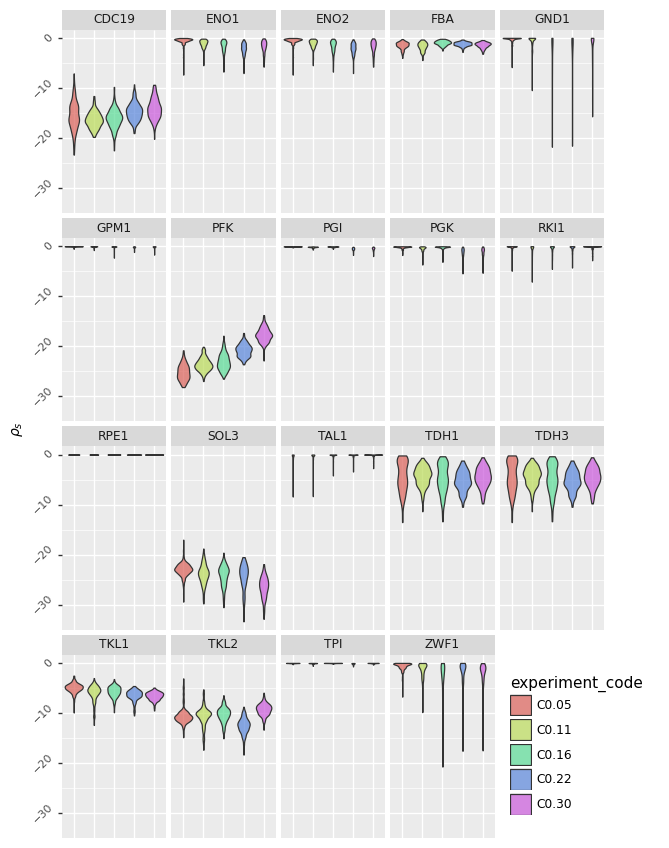

<ggplot: (-9223372036554305904)>


In [564]:
p9.options.figure_size = (7, 10.5)
tmp_dG = regulation_results[~regulation_results['enzyme_code'].isin(["pyr_c_EX", "dhap_c_EX", "r5p_c_EX"])]
tmp_dG['dG'] = tmp_dG['dG'].astype(float)
upper_dG = tmp_dG.groupby(['enzyme_code', 'experiment_code'])['dG'].quantile(0.9)
upper_dG = lower_dG.reset_index()

p_dG = (
    ggplot(data=tmp_dG)
    + p9.geom_violin(aes(y='dG', x='experiment_code', fill='experiment_code'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + p9.labs(y = r'$\rho_{s}$', parse=True)
    + facet_wrap('~enzyme_code', scales="fixed")
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.05,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position=(0.86, 0.2)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
)
    
print(p_dG)
p_dG.save(filename=os.path.join(PATHS['RESULTS'],'04_gibbs_energy_distributions.png'), verbose=False)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_ydensity : Removed 543 rows containing non-finite values.


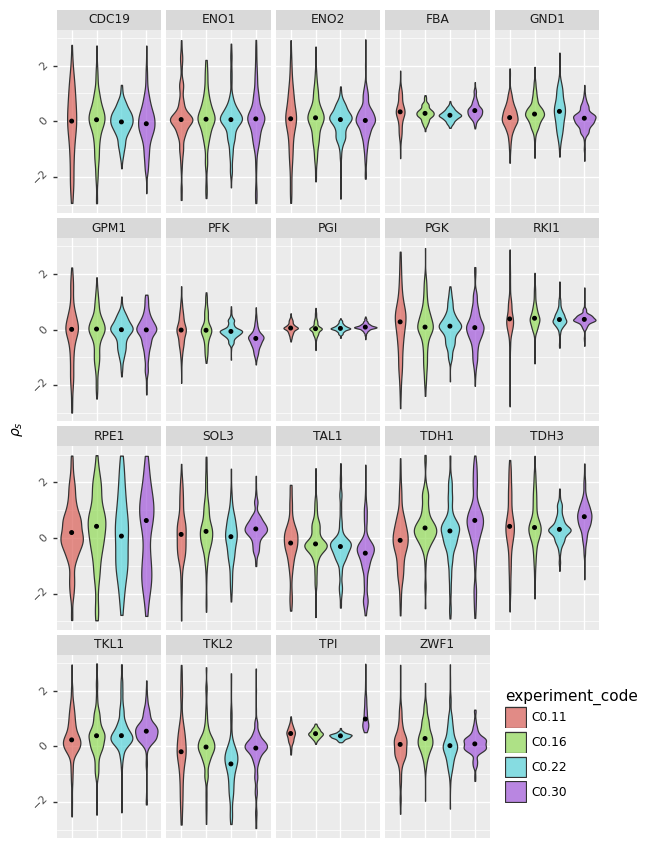

<ggplot: (-9223372036550512019)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_ydensity : Removed 543 rows containing non-finite values.


In [451]:
p9.options.figure_size = (7, 10.5)
tmp_sat = regulation_results[~regulation_results['enzyme_code'].isin(["pyr_c_EX", "dhap_c_EX", "r5p_c_EX"])].dropna()
tmp_sat = tmp_sat[tmp_sat['log_saturation'].abs()<10]
p_sat_reg = (
    ggplot(data=tmp_sat)
    + p9.geom_violin(aes(y='log_saturation', x='experiment_code', fill='experiment_code'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='log_saturation', x='experiment_code'), 
             data=tmp_sat.groupby(["enzyme_code", "experiment_code"]).median().reset_index(), 
             position='identity',
             fill='black',
             size=1)
    + p9.labs(y = r'$\rho_{s}$', parse=True)
    + facet_wrap('~enzyme_code', scales="fixed")
    + p9.scales.ylim(-3, 3)
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.05,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position=(0.86, 0.2)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
)
    
print(p_sat_reg)
p_sat_reg.save(filename=os.path.join(PATHS['RESULTS'],'04_saturation_control_coefficients.png'), verbose=False)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_ydensity : Removed 1255 rows containing non-finite values.


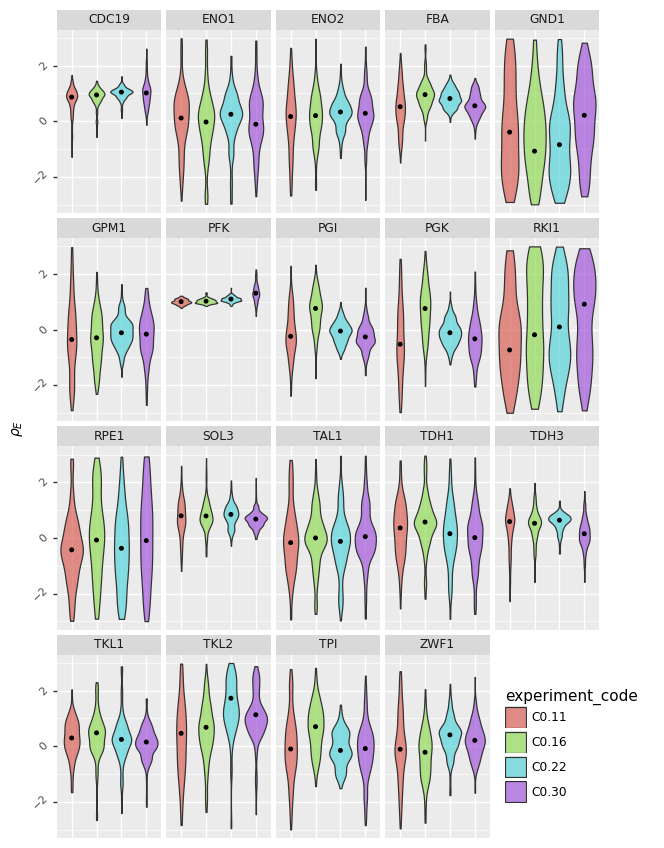

<ggplot: (-9223372036552749687)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_ydensity : Removed 1255 rows containing non-finite values.


In [452]:
p9.options.figure_size = (7, 10.5)
tmp_enz = regulation_results[~regulation_results['enzyme_code'].isin(["pyr_c_EX", "dhap_c_EX", "r5p_c_EX"])].dropna()
tmp_enz = tmp_enz[tmp_enz['log_enzyme'].abs()<10]
p_enz_reg = (
    ggplot(data=tmp_enz)
    + p9.geom_violin(aes(y='log_enzyme', x='experiment_code', fill='experiment_code'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='log_enzyme', x='experiment_code'), 
                 data=tmp_enz.groupby(["enzyme_code", "experiment_code"]).median().reset_index(), 
                 position='identity',
                 fill='black',
                 size=1)
    + p9.labs(y = r'$\rho_{E}$', parse=True)
    + facet_wrap('~enzyme_code', scales="fixed")
    + p9.scales.ylim(-3, 3)
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.05,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position=(0.86, 0.2)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
)
    
print(p_enz_reg)
p_enz_reg.save(filename=os.path.join(PATHS['RESULTS'],'04_enzyme_control_coefficients.png'), verbose=False)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_ydensity : Removed 628 rows containing non-finite values.


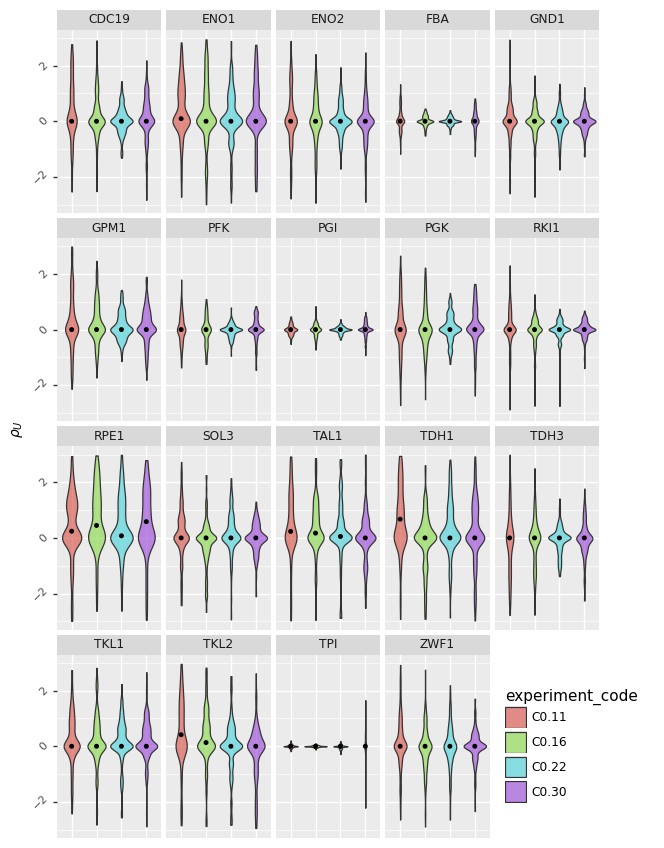

<ggplot: (303429184)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_ydensity : Removed 628 rows containing non-finite values.


In [453]:
p9.options.figure_size = (7, 10.5)
tmp_unaccounted = regulation_results[~regulation_results['enzyme_code'].isin(["pyr_c_EX", "dhap_c_EX", "r5p_c_EX"])].dropna()
tmp_unaccounted = tmp_unaccounted[tmp_unaccounted['unaccounted_change'].abs()<10]
p_un_reg = (
    ggplot(data=tmp_unaccounted)
    + p9.geom_violin(aes(y='unaccounted_change', x='experiment_code', fill='experiment_code'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='unaccounted_change', x='experiment_code'), 
             data=tmp_unaccounted.groupby(["enzyme_code", "experiment_code"]).median().reset_index(), 
             position='identity',
             fill='black',
             size=1)
    + p9.labs(y = r'$\rho_{U}$', parse=True)
    + facet_wrap('~enzyme_code', scales="fixed")
    + p9.scales.ylim(-3, 3)
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.05,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position=(0.86, 0.2)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
)
    
print(p_un_reg)
p_un_reg.save(filename=os.path.join(PATHS['RESULTS'],'04_unaccounted_control_coefficients.png'), verbose=False)

/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_ydensity : Removed 1214 rows containing non-finite values.


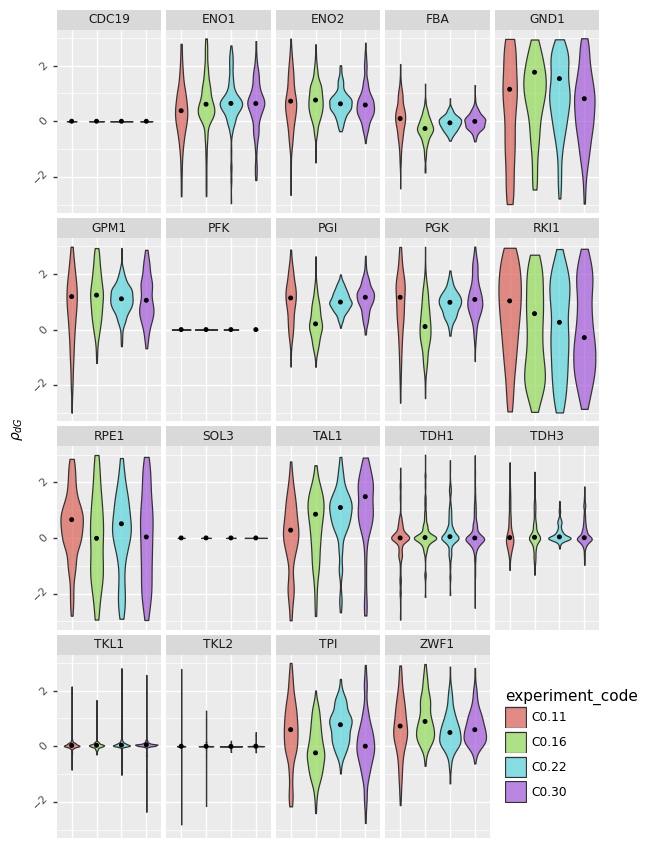

<ggplot: (-9223372036557485701)>


/Users/nicow/.local/share/virtualenvs/Models-rFZ-8aZf/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_ydensity : Removed 1214 rows containing non-finite values.


In [454]:
p9.options.figure_size = (7, 10.5)
tmp_dG = regulation_results[~regulation_results['enzyme_code'].isin(["pyr_c_EX", "dhap_c_EX", "r5p_c_EX"])].dropna()
tmp_dG = tmp_dG[tmp_dG['log_thermodynamic'].abs()<10]
p_dG_reg = (
    ggplot(data=tmp_dG)
    + p9.geom_violin(aes(y='log_thermodynamic', x='experiment_code', fill='experiment_code'), 
                 position='identity',
                 size=0.5,
                 alpha=0.7,
                 weight=0.7,
                 linetype="None")
    + geom_point(aes(y='log_thermodynamic', x='experiment_code'), 
             data=tmp_dG.groupby(["enzyme_code", "experiment_code"]).median().reset_index(), 
             position='identity',
             fill='black',
             size=1)
    + p9.labs(y = r'$\rho_{dG}$', parse=True)
    + facet_wrap('~enzyme_code', scales="fixed")
    + p9.scales.ylim(-3, 3)
    + p9.themes.theme(panel_spacing_y=0.05, 
                      panel_spacing_x=0.05,
                      axis_title=p9.element_text(size=10),
                      axis_text=p9.element_text(size=11),
                      axis_text_y=p9.element_text(size=8, angle = 45),
                      axis_title_x=p9.element_blank(),
                      axis_text_x=p9.element_blank(),
                      axis_ticks_major_x=p9.element_blank(),
                      legend_position=(0.86, 0.2)
                     )
    + p9.scale_x_discrete(labels=experiment_codes, name="condition")
)
    
print(p_dG_reg)
p_dG_reg.save(filename=os.path.join(PATHS['RESULTS'],'04_thermodynamic_control_coefficients.png'), verbose=False)